## Library

In [1]:
!pip install gpytorch
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.1 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2
from typing import Type

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import torchvision.models as models

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

from torchvision import transforms
from scipy.ndimage import rotate
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

import wandb

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<06:34, 390B/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<14:13, 599B/s] 
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<14:21, 564B/s] 
US1_UNCR.dcm:   0%|          | 226/923k [00:00<16:05, 955B/s]   
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<26:54, 3.80kB/s]


In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Init GPU

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: Tesla P100-PCIE-16GB is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

## Config Info

In [6]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 1

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 1
LEARNING_RATE = 1e-4
INDUCING_POINTS = 128

# TARGET_LABELS = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
TARGET_LABELS = ['intraparenchymal']

MODEL_PATH = 'results/trained_model.pth'
DEVICE = 'cuda'

In [7]:
# Kaggle and local switch
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")
ROOT_DIR = '/kaggle/input/rsna-mil-training/' if KAGGLE else None
DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-mil-training/'
DICOM_DIR = DATA_DIR
CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'
# SLICE_LABEL_PATH = ROOT_DIR + "sorted_training_dataset_with_labels.csv" if KAGGLE else './data_analyze/sorted_training_dataset_with_labels.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)
# patient_slice_labels = pd.read_csv(SLICE_LABEL_PATH)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

Running on Kaggle


In [8]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret("Wandb key")

wandb.login(key=key, relogin=True)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
patient_scan_labels.head()

,patient_id,study_instance_uid,images,labels,patient_label,length
0,ID_2e010e33,ID_bda0f47e84,"['ID_b9035cb1e.dcm', 'ID_0713bed86.dcm', 'ID_5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,48
1,ID_43dd2890,ID_43af13416f,"['ID_23864d3ba.dcm', 'ID_f1c65b76e.dcm', 'ID_5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,33
2,ID_93753256,ID_1ee74896bd,"['ID_a3a37df48.dcm', 'ID_61dd5485f.dcm', 'ID_9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,30
3,ID_2d49911c,ID_a71e7c6817,"['ID_93d9cf661.dcm', 'ID_efd4e2780.dcm', 'ID_7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,40
4,ID_cd2cd174,ID_d02e9abf35,"['ID_b437d2e19.dcm', 'ID_0a919428c.dcm', 'ID_d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,33


## Data Preprocessing

In [10]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380

    if CHANNELS == 3:
        bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    else:
        bsb_img = brain_img
    return bsb_img.astype(np.float16)

In [11]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        if CHANNELS == 3:
            return multichannel_slice.astype(np.float16)
        else:
            return slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [12]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
            
    # Sort slices by images position (z-coordinate) in ascending order
    slices = sorted(slices, key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Dataset and DataLoader

### Splitting the Dataset

In [13]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels['patient_label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['patient_label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

### Processing the Data

In [14]:
def process_patient_data(dicom_dir, row, num_instances=12, depth=5):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        
        # Ensure we have enough slices to create the specified instances
        if len(slices) < depth * num_instances:
            print(f"Not enough slices for patient {patient_id}: found {len(slices)}, needed {depth * num_instances}")
            return None, None
        
        preprocessed_slices = [torch.tensor(preprocess_slice(slice), dtype=torch.float32) for slice in slices]  # Convert to tensor
        
        # Stack preprocessed slices into an array
        preprocessed_slices = torch.stack(preprocessed_slices, dim=0)  # (num_slices, height, width, channels)
    
        # Labels are already in list form, so just convert them to a tensor
        labels = torch.tensor(row['labels'], dtype=torch.long)
        
        # Fill labels with 0s if necessary
        if len(preprocessed_slices) > len(labels):
            padded_labels = torch.zeros(len(preprocessed_slices), dtype=torch.long)
            padded_labels[:len(labels)] = labels
        else:
            padded_labels = labels[:len(preprocessed_slices)]
        
        return preprocessed_slices, padded_labels
    
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

### Augmentation

In [15]:
import random

In [16]:
class DatasetAugmentor:
    def __init__(self, height, width, seed=None):
        self.height = height
        self.width = width
        self.seed = seed
        
        # Store parameters for consistency checks with non-overlapping ranges
        self.min_params = self._create_transform(5, (0.05, 0.05), (0.95, 1.05), 
                                                  brightness_range=0.05, contrast_range=0.05,
                                                  blur_sigma_range=(0.1, 0.2), apply_elastic=False, level_name='min')
        self.med_params = self._create_transform(10, (0.1, 0.1), (0.9, 1.1), 
                                                  brightness_range=0.1, contrast_range=0.1,
                                                  blur_sigma_range=(0.2, 0.5), apply_elastic=True, level_name='med')
        self.max_params = self._create_transform(15, (0.2, 0.2), (0.8, 1.2), 
                                                  brightness_range=0.2, contrast_range=0.2,
                                                  blur_sigma_range=(0.5, 1.0), apply_elastic=True, level_name='max')

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range,
                      brightness_range, contrast_range,
                      blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")

        # Sample specific values and take the absolute value for positivity
        sampled_degrees = abs(self._sample_value((-degrees, degrees)) if isinstance(degrees, int) else degrees)
        sampled_translate_x = abs(self._sample_value(translate_range[0]))
        sampled_translate_y = abs(self._sample_value(translate_range[1]))
        sampled_scale = self._sample_value(scale_range)
        sampled_brightness = self._sample_value(brightness_range)
        sampled_contrast = self._sample_value(contrast_range)
        sampled_blur_sigma = self._sample_value(blur_sigma_range)

        # Print specific sampled values
        print(f"  Degrees: {sampled_degrees}, Translate: ({sampled_translate_x}, {sampled_translate_y}), Scale: {sampled_scale}")
        print(f"  Brightness: {sampled_brightness}, Contrast: {sampled_contrast}")
        print(f"  Blur Sigma: {sampled_blur_sigma}, Apply Elastic: {apply_elastic}")

        return {
            "degrees": sampled_degrees,
            "translate": (sampled_translate_x, sampled_translate_y),
            "scale": sampled_scale,
            "brightness": sampled_brightness,
            "contrast": sampled_contrast,
            "blur_sigma": sampled_blur_sigma,
            "apply_elastic": apply_elastic
        }

    def apply_transform(self, image, level):
        channels = image.shape[0]
        
        if self.seed is not None:
            torch.manual_seed(self.seed)
            random.seed(self.seed)

        if level == 0:
            params = self.min_params
            transform = self._get_transform(params, channels)
        elif level == 1:
            params = self.med_params
            transform = self._get_transform(params, channels)
        else:
            params = self.max_params
            transform = self._get_transform(params, channels)

        transformed_image = transform(image)        
        return transformed_image

    def _get_transform(self, params, channels=3):
        transform_list = [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(HEIGHT),
            transforms.ToTensor(),
        ]

        if channels == 3:
            transform_list.extend([
                transforms.Normalize(mean=[0.16774411, 0.1360026, 0.19076315], std=[0.3101935, 0.27605791, 0.30469988]),
                transforms.RandomApply([self._channel_shuffle], p=0.3)
            ])
        elif channels == 1:
            transform_list.append(transforms.Normalize(mean=[0.16774411], std=[0.3101935]))

        return transforms.Compose(transform_list)

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

In [17]:
augmentor = DatasetAugmentor(224, 224, seed=42)

Creating 'min' transform with parameters:
  Degrees: 1.3942679845788373, Translate: (0.05, 0.05), Scale: 1.0139426798457885
  Brightness: 0.05, Contrast: 0.05
  Blur Sigma: 0.16394267984578836, Apply Elastic: False
Creating 'med' transform with parameters:
  Degrees: 2.7885359691576745, Translate: (0.1, 0.1), Scale: 1.027885359691577
  Brightness: 0.1, Contrast: 0.1
  Blur Sigma: 0.3918280395373651, Apply Elastic: True
Creating 'max' transform with parameters:
  Degrees: 4.182803953736514, Translate: (0.2, 0.2), Scale: 1.0557707193831534
  Brightness: 0.2, Contrast: 0.2
  Blur Sigma: 0.8197133992289418, Apply Elastic: True


### Dataset Generator

In [18]:
class MedicalScanDataset(Dataset):
    """
    Base dataset class for processing medical scan data.
    Handles data loading, preprocessing, and normalization of medical scan images.
    """
    def __init__(self, data_dir, patient_scan_labels, augmentor):
        self.data_dir = data_dir
        self.patient_scan_labels = self._parse_patient_scan_labels(patient_scan_labels)
        self.augmentor = augmentor

    def _parse_patient_scan_labels(self, patient_scan_labels):
        """Parse and validate patient scan labels."""
        patient_scan_labels['images'] = patient_scan_labels['images'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        )
        patient_scan_labels['labels'] = patient_scan_labels['labels'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        )
        patient_scan_labels['patient_label'] = patient_scan_labels['patient_label'].astype(bool)
        return patient_scan_labels

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        """Get a single item from the dataset."""
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, labels = self._process_patient_data(row)
        
        if preprocessed_slices is None:
            return None, None, None
            
        preprocessed_slices = self._prepare_tensor(preprocessed_slices)
        patient_label = torch.tensor(bool(row['patient_label']), dtype=torch.uint8)
        
        return preprocessed_slices, labels, patient_label

    def _process_patient_data(self, row):
        """Process patient data to get preprocessed slices and labels."""
        return process_patient_data(self.data_dir, row)

    def _prepare_tensor(self, preprocessed_slices):
        """Convert preprocessed slices to normalized tensor."""
        preprocessed_slices = np.array(preprocessed_slices)
        preprocessed_slices = torch.tensor(preprocessed_slices, dtype=torch.float32)

        if preprocessed_slices.ndim == 3:  # Grayscale
            preprocessed_slices = preprocessed_slices.unsqueeze(1)  # Add channel dimension
            return torch.stack([self.augmentor.apply_transform(img, level=0) for img in preprocessed_slices])
        elif preprocessed_slices.ndim == 4:  # RGB
            preprocessed_slices = preprocessed_slices.permute(0, 3, 1, 2) 
            return torch.stack([self.augmentor.apply_transform(img, level=0) for img in preprocessed_slices])
        else:
            raise ValueError(f"Unexpected number of dimensions: {preprocessed_slices.ndim}")

In [19]:
class TrainDatasetGenerator(MedicalScanDataset):
    """Dataset class for training medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor):
        super().__init__(data_dir, patient_scan_labels, augmentor)

class TestDatasetGenerator(MedicalScanDataset):
    """Dataset class for testing medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor):
        super().__init__(data_dir, patient_scan_labels, augmentor)

In [20]:
original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor)

In [21]:
len(original_dataset)

1000

In [22]:
x,y,z = original_dataset[0]
print(x.shape, y.shape, z.shape)

torch.Size([60, 1, 224, 224]) torch.Size([60]) torch.Size([])


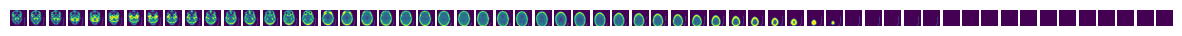

In [23]:
import matplotlib.pyplot as plt

# Check if the returned data is valid
if x is not None:
    # Convert the tensor to a numpy array
    x_np = x.numpy()

    # Check the number of dimensions and squeeze if necessary
    if x_np.ndim == 4:  # RGB images
        # Plot each slice
        fig, axes = plt.subplots(1, x_np.shape[0], figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow(x_np[i].transpose(1, 2, 0))  # Convert CHW to HWC
            ax.axis('off')
        plt.show()
    elif x_np.ndim == 3:  # Grayscale images
        # Plot each slice
        fig, axes = plt.subplots(1, x_np.shape[0], figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow(x_np[i], cmap='gray')
            ax.axis('off')
        plt.show()
    else:
        raise ValueError(f"Unexpected number of dimensions: {x_np.ndim}")
else:
    print("No data available for this patient.")


In [24]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=augmentor)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=augmentor)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## CNN Feature Extractor

### GP Model

In [25]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Attention Layer

In [26]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            # nn.ReLU(),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attention_weights = self.attention(x)
        weights = F.softmax(attention_weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

In [27]:
class GatedAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GatedAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))
        
        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)
        
        return (x * weights).sum(dim=1), weights.squeeze(-1)

### Mixed Pooling

In [28]:
class MixedPooling(nn.Module):
    def __init__(self, in_channels: int, alpha: float=0.5):
        super(MixedPooling, self).__init__()
        self.alpha = alpha
        
        # Convolution layer
        self.conv = nn.Conv2d(in_channels, 16, kernel_size=1)  # Adjust output channels as needed
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

    def forward(self, x):
        # Perform average pooling and apply weight
        avg_out = self.avgpool(x)
        avg_out_weighted = avg_out * self.alpha
        
        # Perform max pooling and apply weight
        max_out = self.maxpool(x)
        max_out_weighted = max_out * (1 - self.alpha)

        # Add the weighted outputs together
        # combined = avg_out_weighted + max_out_weighted
        combined = torch.cat((avg_out_weighted, max_out_weighted), dim=1)  # Concatenate along channel dimension
        combined = self.conv(combined)  # Reduce channels
        return combined  # Output with combined features

### ResNet2D Model

#### ResNet2D Model

In [29]:
class MILResNet18(nn.Module):
    def __init__(self):
        super(MILResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

        self.resnet.fc = nn.Identity()
        self.attention = AttentionLayer(input_dim=512, hidden_dim=512)
        self.classifier = nn.Linear(512 + 1, 1)
        self.dropout = nn.Dropout(0.35)

        # Define inducing points for the GP layer
        inducing_points = torch.randn(32, 512)
        # inducing_points = torch.full((256, 512), 1e-20)  
        self.gp_layer = GPModel(inducing_points)

    def forward(self, bags):
        # batch_size, num_instances = bags.size(0), bags.size(1)
        # bags_flattened = bags.view(-1, *bags.shape[2:])
        # batch_size, num_instances, h, w, c = bags.size()
        # bags_flattened = bags.view(batch_size * num_instances, c, h, w)
#         if CHANNELS == 1:
#             batch_size, num_instances, h, w = bags.size()
#             bags_flattened = bags.view(batch_size * num_instances, CHANNELS, h, w)
#         else:
        batch_size, num_instances, c, h, w = bags.size()
        bags_flattened = bags.view(batch_size * num_instances, c, h, w)

        features = self.resnet(bags_flattened)
        features = features.view(batch_size, num_instances, -1)
        attended_features, attended_weights = self.attention(features)

        attended_features_reshaped = attended_features.view(-1, 512)

        gp_output = self.gp_layer(attended_features_reshaped)
        gp_mean = gp_output.mean.view(batch_size, -1)

        combine_features = torch.cat((attended_features, gp_mean), dim=1)
        combine_features = self.dropout(combine_features)

        outputs = torch.sigmoid(self.classifier(combine_features))
        return outputs, attended_weights

## Training and Evaluation

#### Loss Function

In [30]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    # Cross-Entropy Loss for CNN outputs
    bce_loss = nn.BCELoss()(outputs.squeeze(), target.float())
    kl_divergence = gp_distribution.variational_strategy.kl_divergence()
    total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    
    return total_loss

### Training

In [31]:
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    for batch_data, batch_labels, batch_patient_labels in data_loader:
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs, attention_weights = model(batch_data)
        outputs = outputs.squeeze()
        loss = combined_loss(outputs, model.gp_layer, batch_patient_labels, alpha)
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Store predictions and labels
        predictions.extend((outputs > 0.5).cpu().detach().numpy())
        labels.extend(batch_patient_labels.cpu().numpy())

    return total_loss, predictions, labels

def validate(model, data_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            
            # Forward pass
            outputs, attention_weights = model(batch_data)
            outputs = outputs.squeeze()
            loss = combined_loss(outputs, model.gp_layer, batch_patient_labels, alpha)
            total_loss += loss.item()
    
            # Store predictions and labels
            predictions.extend((outputs > 0.5).cpu().detach().numpy())
            labels.extend(batch_patient_labels.cpu().numpy())

    return total_loss, predictions, labels

def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch+1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                              steps_per_epoch=len(train_loader), epochs=num_epochs)
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)
        # Log training metrics to W&B
        wandb.log({"train/loss": train_loss / len(train_loader), **train_metrics})

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, val_loader, criterion, device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)
        # Log validation metrics to W&B
        wandb.log({"val/loss": val_loss / len(val_loader), **val_metrics})

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    # Optionally log the best model to W&B (if desired)
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))
    
    return model

### Evaluation Functions

In [32]:
## Model Evaluation Functions
def evaluate_model(model, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    model.eval()
    predictions = []
    labels = []
    with torch.inference_mode(): # Torch.inference_mode() is equivalent to torch.no_grad(), but it's faster and consumes less memory!!!
        for batch_data, batch_labels, batch_patient_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)

            outputs, attention_weights = model(batch_data)
            outputs = outputs.squeeze()
            predictions.extend((outputs > 0.5).cpu().detach().numpy())
            labels.extend(batch_patient_labels.cpu().numpy())

    return np.array(predictions), np.array(labels)

def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

### Visualization Functions

In [33]:
## Visualization Functions
def plot_roc_curve(model, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    # predictions, labels = evaluate_model(model, data_loader, device)
    
    model.eval()
    labels = []
    predictions = []
    
    with torch.inference_mode():
        for batch_data, batch_labels, batch_patient_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)

            outputs, attention_weights = model(batch_data)
            outputs = outputs.squeeze()
            predictions.extend(outputs.cpu().numpy())
            labels.extend(batch_patient_labels.cpu().numpy())
            
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, data_loader, device):
    """Plot the confusion matrix for the model predictions."""
    predictions, labels = evaluate_model(model, data_loader, device)
    
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Processing Functions

In [34]:
## Data Processing Functions
def load_model(model_class, model_path):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class()
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader)
    
    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)
    
    return pd.DataFrame(results)

## Visualizing Attention Weights and Images

In [35]:
def plot_label_attention_weights(model, data_loader, device='cuda'):
    """
    Plot images with their labels and attention values in a single large plot.

    Parameters:
    - model: The trained model
    - data_loader: DataLoader containing test dataset
    - device: Device to run the model on ('cuda' or 'cpu')
    - CHANNELS: Number of channels in the image (e.g., 1 for grayscale, 3 for RGB)

    Expected shapes:
    - 1-channel images: (batch_size, num_images, 224, 224)
    - 3-channel images: (batch_size, num_images, 3, 224, 224)
    - attention: float value per image indicating attention weight
    """
    model = model.to(device)
    model.eval()
    num_images = 60
    rows, cols = 10, 6  # Adjust to fit 60 images in a single plot

    with torch.no_grad():
        for batch_data, batch_labels, batch_patients_label in data_loader:
            # Move data to the appropriate device
            batch_data = batch_data.to(device)
            outputs, attention_weight_batch = model(batch_data)

            # Process each patient in the batch
            for patient_idx in range(batch_data.size(0)):
                if batch_patients_label[patient_idx].item() == 1:  # Check if patient has positive label
                    # Create a new figure for this patient
                    fig = plt.figure(figsize=(cols * 4, rows * 4 + 2))  # Increased height for suptitle

                    for img_idx in range(num_images):
                        # Get the image and its label
                        img = batch_data[patient_idx, img_idx].cpu().numpy()
                        img_label = batch_labels[patient_idx, img_idx].cpu().numpy()
                        
                        # Get attention value
                        if attention_weight_batch.size(1) == batch_data.size(1):
                            attention_value = attention_weight_batch[patient_idx, img_idx].cpu().item()
                        else:
                            attention_value = attention_weight_batch[patient_idx].cpu().item()
                        
                        # Plot image
                        plt.subplot(rows, cols, img_idx + 1)
                        if CHANNELS == 3:  # RGB image
                            plt.imshow(img)
                        else:  # Grayscale image
                            if img.ndim == 3:  # If shape is (1, H, W)
                                img = np.squeeze(img)  # Convert to (H, W)
                            plt.imshow(img, cmap='gray')
                        
                        plt.title(f'Label: {img_label}\nAttention: {attention_value:.4f}', fontsize=12)
                        plt.axis('off')

                    # Add overall title for the patient
                    plt.suptitle(f'Patient Images (Patient Label: {batch_patients_label[patient_idx].cpu().numpy()})', fontsize=16)
                    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to make space for suptitle
                    plt.show()
                                      
                    # Since we are plotting only for one patient, return after the first plot
                    return

## Main

In [36]:
def set_seed(seed=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

wandb: Currently logged in as: nhatminhtrieu (huynhsikha2003-i-h-c-qu-c-gia-tp-hcm). Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s] 


Epoch 1/1 - Train:
Loss: 28.4060, Accuracy: 0.6286, Precision: 0.6154, Recall: 0.6857, F1: 0.6486
Epoch 1/1 - Validation:
Loss: 10.8252, Accuracy: 0.6867, Precision: 0.6842, Recall: 0.6933, F1: 0.6887
Test Accuracy: 0.6533, Precision: 0.6456, Recall: 0.6800, F1: 0.6623


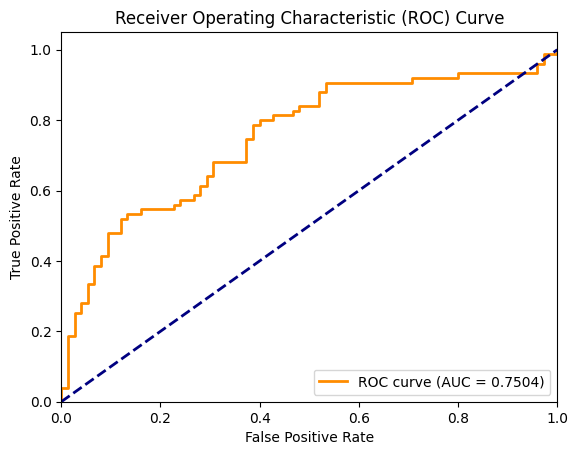

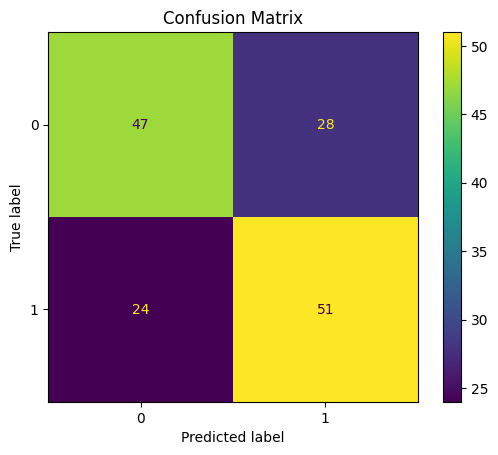

    patient_id study_instance_uid  patient_label  prediction
0  ID_97270045      ID_919be94ef6          False        True
1  ID_e94cf8c1      ID_b4d78b65b7           True       False
2  ID_17d6af95      ID_42bcacea9e          False       False
3  ID_26b9477b      ID_2f19863f0a          False       False
4  ID_2efa6002      ID_74218831ef           True       False


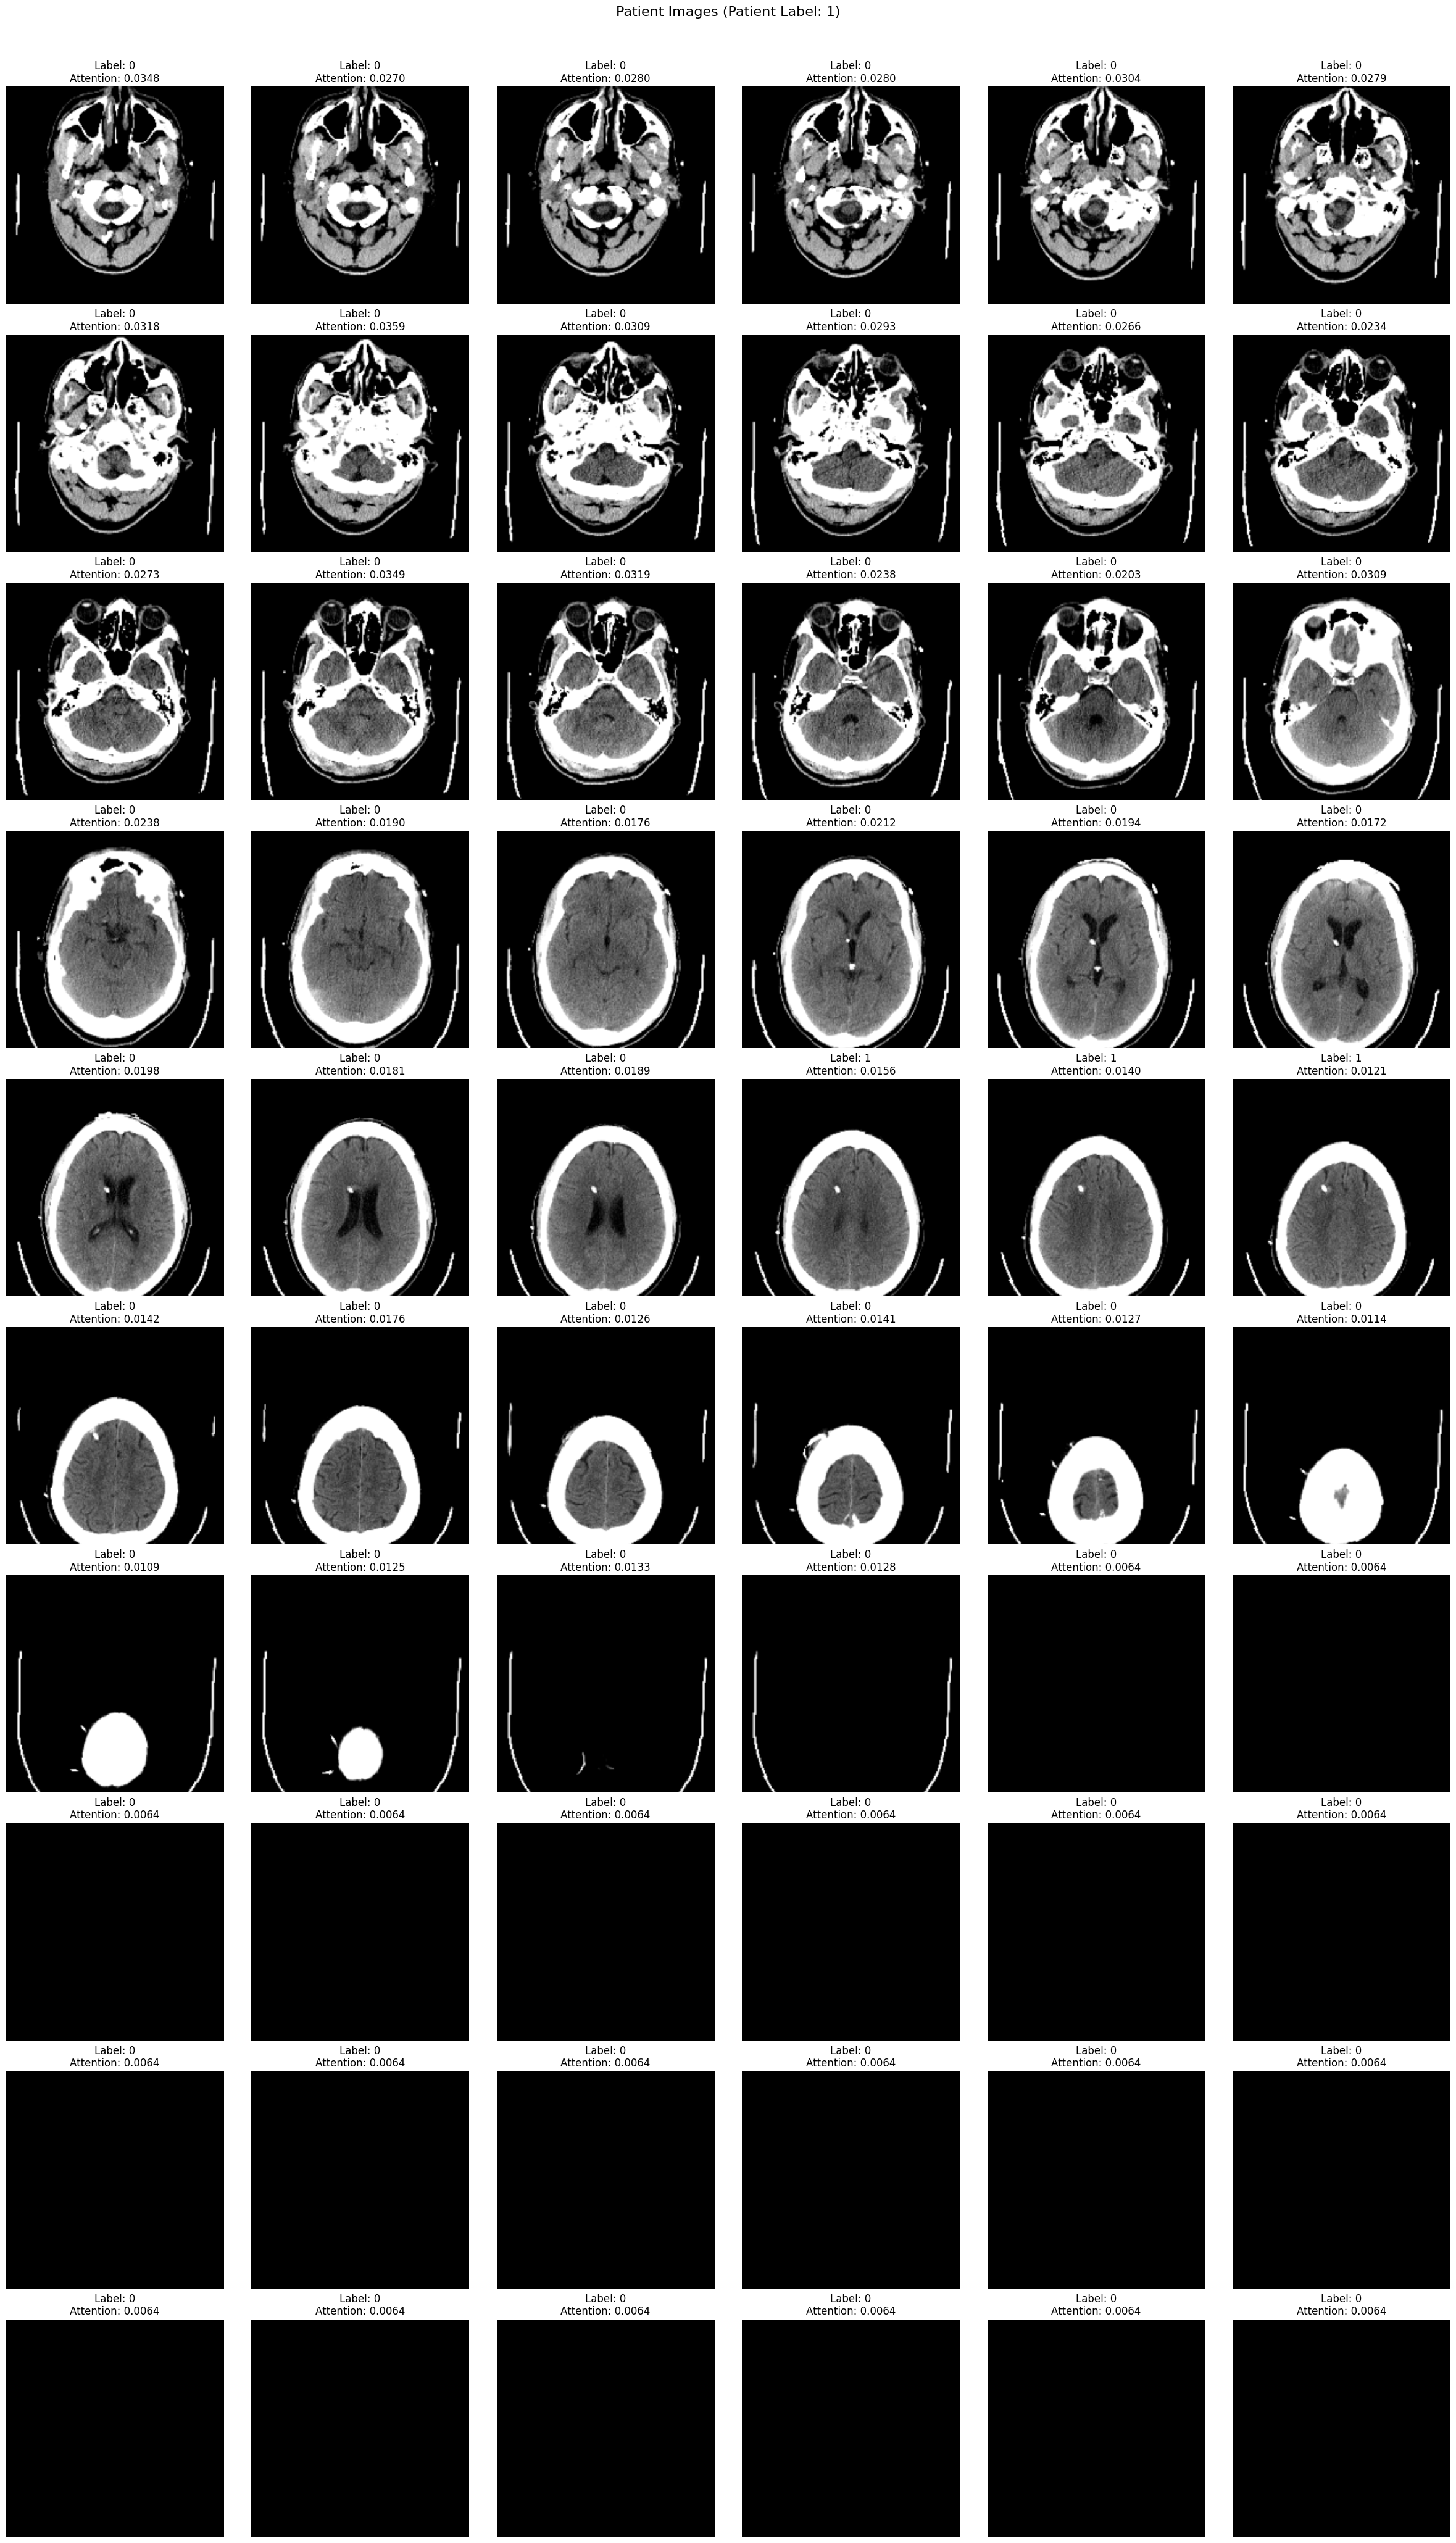

In [37]:
def main(mode='train'):
    # Initialize W&B
    wandb.init(project="your_project_name")
    
    # Log hyperparameters
    config = wandb.config
    config.learning_rate = LEARNING_RATE
    config.batch_size = TRAIN_BATCH_SIZE
    config.num_epochs = NUM_EPOCHS

    set_seed()
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)

    set_seed()
    
    # Initialize model, criterion, and optimizer
    model = MILResNet18()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    if mode == 'train':
        # Watch the model to log gradients and parameters
        wandb.watch(model)

        # Train model
        trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, config.num_epochs, config.learning_rate, DEVICE)

        # Save model
        torch.save(trained_model.state_dict(), MODEL_PATH)

    # Load best model
    trained_model = load_model(MILResNet18, MODEL_PATH)

    # Evaluate model
    predictions, labels = evaluate_model(trained_model, test_loader, DEVICE)
    metrics = calculate_metrics(predictions, labels)
    
    # Log metrics to W&B
    wandb.log(metrics)

    print_metrics(metrics)

    # Visualizations
    plot_roc_curve(trained_model, test_loader, DEVICE)
    plot_confusion_matrix(trained_model, test_loader, DEVICE)

    if mode == 'train':
        required_columns = ['patient_id', 'study_instance_uid', 'patient_label']
        temp_test_labels = test_labels[required_columns]
        
        # Save results
        results_df = get_test_results(trained_model, test_loader, temp_test_labels)
        results_df.to_csv('results/results.csv', index=False)
        print(results_df.head())

        # Log results DataFrame as a table in W&B (optional)
        wandb.log({"results": wandb.Table(dataframe=results_df)})

    # Call the function with the test_loader
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    plot_label_attention_weights(trained_model, test_loader)

if __name__ == "__main__":
    main(mode='train')

## Results